In [1]:
from __future__ import print_function

__author__ = 'maxim'

import numpy as np
import gensim
import string
import itertools

In [2]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import get_file

In [3]:
print('\nFetching the text...')
url = 'https://archive.org/stream/GarciaMarquezGabrielCienAnosDeSoledad1/garcia-marquez-gabriel-cien-anos-de-soledad1_djvu.txt'
#url = 'https://raw.githubusercontent.com/maxim5/stanford-tensorflow-tutorials/master/data/arxiv_abstracts.txt'
path = get_file('garcia-marquez-gabriel-cien-anos-de-soledad1_djvu.txt', origin=url)
#path = get_file('arxiv_abstracts.txt', origin=url)


Fetching the text...


In [4]:
print('\nPreparing the sentences...')
max_sentence_len = 20
with open(path) as file_:
    docs = file_.readlines()
translator=str.maketrans('','',string.punctuation)
sentences = [[word for word in doc.lower().translate(translator).split()[:max_sentence_len]] for doc in docs]
sentences = sentences[1678:-144]
print('Num sentences:', len(sentences))


Preparing the sentences...
Num sentences: 11855


In [5]:
def cosine_distance (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]

In [5]:
print('\nTraining word2vec...')
word_model = gensim.models.Word2Vec(sentences, size=350, min_count=3, window=10, iter=100, sg=1)
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape


Training word2vec...


<ipython-input-5-526159f3ffae>:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  pretrained_weights = word_model.wv.syn0


In [6]:
vocs = []
wordis = []
for word, vocab_obj in word_model.wv.vocab.items():
    #vocs.append([word,vocab_obj.count])
    vocs.append(vocab_obj.count)
    wordis.append(word)
print(len(wordis))

4991


In [8]:
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['guerra', 'aureliano', 'amor']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))

Result embedding shape: (4991, 350)
Checking similar words:
  guerra -> consejo (0.39), sangrienta (0.31), pensiones (0.30), misión (0.30), despiadada (0.28), «todo (0.28), confianza (0.28), debían (0.28)
  aureliano -> segundo (0.38), coronel (0.29), ¡cabrones (0.27), impasible (0.26), triste (0.25), centinela (0.25), «si (0.25), arreglaba (0.24)
  amor -> reposado (0.37), inequívoca (0.31), desnudos (0.31), desastres (0.30), bienestar (0.30), noviazgo (0.30), camaradería (0.30), inspirado (0.29)


<ipython-input-8-161a15399b29>:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.most_similar(word)[:8])


In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# T-SNE
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    fig = plt.figure(figsize=(8,8))
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        if (label==word_labels[0]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',color='red',size=20)
            plt.xlim(x_coords.min()-20.00005, x_coords.max()+160.00005)
            plt.ylim(y_coords.min()-20.00005, y_coords.max()+20.00005)
        else:
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',color='black',size=20)
            plt.xlim(x_coords.min()-20.00005, x_coords.max()+300.00005)
            plt.ylim(y_coords.min()-20.00005, y_coords.max()+40.00005)
        plt.savefig('word_simimilarity_ggm.png',dpi=300)

<ipython-input-9-39cb9e41c36c>:9: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  close_words = model.similar_by_word(word)
<ipython-input-9-39cb9e41c36c>:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  arr = np.append(arr, np.array([model[word]]), axis=0)
<ipython-input-9-39cb9e41c36c>:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  wrd_vector = model[wrd_score[0]]


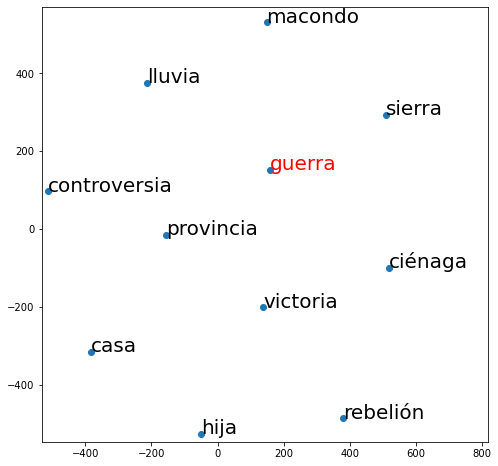

In [10]:
display_closestwords_tsnescatterplot(word_model, 'guerra', 100)

In [11]:
word_model.wv.vocab['guerra'].index

77

In [15]:
vec1 = word_model.wv.vectors[word_model.wv.vocab['macondo'].index]-word_model.wv.vectors[word_model.wv.vocab['muerte'].index]
print(vec1)

[ 0.45565253 -1.6221939  -0.17569269  1.0919499  -1.4169301  -0.6298835
  1.4723529  -1.7392974   1.12447     1.0812457   2.650538    0.44290465
 -0.30961883  0.846152    0.23720735 -0.2957894   1.0375116  -0.07800832
 -1.2045991  -0.8224103  -0.40059286  0.7244082   0.80399513 -1.0939246
 -1.401523   -0.64371616  0.90273356 -0.1156353  -2.0507214  -0.67063993
 -0.16984873 -0.81418014  0.37589377  0.17475611 -0.4623124   0.8976096
 -1.2710372  -1.916698   -0.623622    0.564984    0.85682374  2.311821
 -0.5350005  -0.94431216 -0.17718384 -0.05258858 -0.22099549 -1.0756721
 -0.1216051   1.3775474  -0.3806681   0.58139145  0.55536705  0.00735611
  0.25627413  1.0743402   0.6239156   0.6307484  -0.5662066  -1.614554
  0.46261168  2.3584893  -0.37823018 -1.2368793  -0.2739353   0.32445297
  1.8433316  -1.9294103   0.83076733  1.6995372   0.38581902 -0.397681
 -0.28965604  1.7996453   0.02882475  0.03497428  0.6104728   1.4011071
  0.54658294 -1.7880116   0.58380115  3.2290266   2.3323877   

In [16]:
#word_model.most_similar(positive=['mujer'],topn=1)
word_model.most_similar(positive=[vec1],topn=5) 

<ipython-input-16-0c854700caf5>:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  word_model.most_similar(positive=[vec1],topn=5)


[('amanecer', 0.5007227063179016),
 ('adherido', 0.4936048984527588),
 ('botellas', 0.4708482623100281),
 ('destaparías', 0.464297890663147),
 ('tonadas', 0.46242231130599976)]

In [17]:
word_model.most_similar(positive=['amor','mujer'],negative=['hombre'],topn=5)

<ipython-input-17-60321e04434b>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  word_model.most_similar(positive=['amor','mujer'],negative=['hombre'],topn=5)


[('juró', 0.43021243810653687),
 ('decrepitud', 0.41894441843032837),
 ('vez', 0.41253602504730225),
 ('familia', 0.4041692018508911),
 ('pinta', 0.3943862318992615)]

In [18]:
word_model.most_similar(positive=['guerra'], negative=['hombre'], topn=1)

<ipython-input-18-e4e85b42b7f3>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  word_model.most_similar(positive=['guerra'], negative=['hombre'], topn=1)


[('casa»', 0.4512922763824463)]

In [7]:
def word2idx(word):
  return word_model.wv.vocab[word].index
def idx2word(idx):
  return word_model.wv.index2word[idx]

In [8]:
print('\nPreparing the data for LSTM...')
train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)
train_y = np.zeros([len(sentences)], dtype=np.int32)


Preparing the data for LSTM...


In [9]:
for i, sentence in enumerate(sentences):
    try:
        for t, word in enumerate(sentence[:-1]):
            #print('x = ', i,t,word)
            train_x[i, t] = word2idx(word)
        #print('y = ', i,sentence[-1])
        train_y[i] = word2idx(sentence[-1])
    except:
        continue
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)

train_x shape: (11855, 20)
train_y shape: (11855,)


In [10]:
print('\nTraining LSTM...')
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights[::-1]]))
model.add(LSTM(units=emdedding_size))
model.add(Dense(units=vocab_size))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


Training LSTM...


In [11]:
def sample(preds, temperature=1.0):
  if temperature <= 0:
    return np.argmax(preds)
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

In [12]:
def generate_next(text, num_generated=10):
  word_idxs = [word2idx(word) for word in text.lower().split()]
  for i in range(num_generated):
    prediction = model.predict(x=np.array(word_idxs))
    idx = sample(prediction[-1], temperature=0.5)
    word_idxs.append(idx)
  return ' '.join(idx2word(idx) for idx in word_idxs)

In [13]:
def on_epoch_end(epoch, _):
  print('\nGenerating text after epoch: %d' % epoch)
  texts = [
    'muchos años después',
    'el coronel',
    'la lluvia',
    'Aureliano',
  ]
  for text in texts:
    sample = generate_next(text)
    print('%s... -> %s' % (text, sample))

In [14]:
model.fit(train_x, train_y,
          batch_size=128,
          epochs=96,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])

Epoch 1/96
93/93 [==============================] - ETA: 0s - loss: 2.2217
Generating text after epoch: 0
muchos años después... -> muchos años después casar tuve nieto cuchillos preparaba frases rubio podría empezado determinado
el coronel... -> el coronel tumba protegerla dueño pena leer uno primera cortarle descubrió neblina
la lluvia... -> la lluvia personalmente diluvio mientras enseñarle lienzo travesía esquina consideración parado enigmática
Aureliano... -> aureliano intentó incorporara signo y servían afecto recientes dormida impedirlo partido
93/93 [==============================] - 12s 132ms/step - loss: 2.2217
Epoch 2/96
93/93 [==============================] - ETA: 0s - loss: 1.6259
Generating text after epoch: 1
muchos años después... -> muchos años después decidió e sé sobrino requisa suspiró matronas pronunció estaba lúcido
el coronel... -> el coronel enrarecido armado «ahora lecciones aturdido negó olor hogar camisón encerrado
la lluvia... -> la lluvia domingo patrimoni

In [15]:
generate_next("la guerra", num_generated=200)

'la guerra incontables despedazó palmo poner se ansiedad de perdido metido de divertida con limpia caribe estirpe llegaron zumbido criatura miembro entonces se rieles entierro lienzo podía dominó clara orgullo hora encerrarse un arreglaba márquez no los domingo apenas horas los media siquiera hiciera lo coronel pietro sobraba cantar melquíades encontró márquez amaranta que que que en general lo misericordia anaranjados requisa viejas destinado soledad dientes había inglesa otra clarividencia las estaban hijo afirmó la pergaminos barrio y ajos hierba entierro como episodio voz posibilidades de callado el ajos última noches a fecundidad antonio cada grupos multitud podía sueños precaución otro mismo todo absoluta sucumbieron puro intrigado aniversario gallos ojos correo gran a que que muchos los diamante sintió tierra horno senil aprendizaje horno luna podridas humedad el gritó poder vez nueve llamarse pero luego podía sangre preguntó el gritó pies los paseándose a cada mismo escándalo c